In [1]:
# Standard library imports
import os
import json
import cPickle as pickle

# Additional library imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.style.use('seaborn-white')

In [3]:
class myEncoder(json.JSONEncoder):
    def default(self, obj):
        return {'_python_object': pickle.dumps(obj)}

def as_python_object(dct):
    if '_python_object' in dct:
        return pickle.loads(str(dct['_python_object']))
    return dct

In [4]:
def read_image(path):
    """Read image int RGB array."""
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

def summary(filename, structure, im, contours, json_path=None):
    """Generate dictionary of summary informaiton about image segments."""

    center = []
    area = []
    for c in contours:
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cv2.circle(im, (cX, cY), 7, (255, 255, 255), -1)
        a = cv2.contourArea(c)
        center.append((cX, cY))
        area.append(a)

    output = { 
        'area': area,
        'center': center,
        'contour_(x,y)': contours,
        'img_file': filename,
        'structure': structure,
    }

    if json_path:
        with open(json_path, 'w') as outfile:
            json.dump(output, outfile, cls=myEncoder)

    return output

In [5]:
def green_cell(im):
    """Functions to segment green cells."""

    def normalize_image(im):
        """Normalize image."""
        R, G, B = cv2.split(im)    
        G_norm = cv2.normalize(G, G, 0, 175, cv2.NORM_MINMAX)
        im = cv2.merge((R, G_norm, B)) 
        return im

    def find_contours(im):
        """Segment image returning list of segment contours."""

        im_norm = normalize_image(im)
        im_blur = cv2.GaussianBlur(im_norm, (93,93),0)
        thresh = cv2.inRange(im_blur, np.array([0,55,40]), np.array([60,255,255]))
        _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        contours = [c for c in contours if cv2.contourArea(c) > 400]
        return contours

    def draw_contours(im, contours):
        """Draw contours on image."""

        for i in range(len(contours)):
            cv2.drawContours(im, contours, i, (250,220,55), thickness=4, lineType=2, maxLevel=0)
        return im

    im1 = normalize_image(im)
    contours = find_contours(im1)
    draw_contours(im1, contours)
    return contours, im1

### Create a dictionary of image segmentation functions for different structures

In [6]:
# only one for now, but you can add more by creating more rules as in `green_cells()` above

rules = {
    'green_cells': green_cell,
}

### Test on a few images

In [7]:
base_dir = '/Users/cliburn/Dropbox/LungMapImages'
filename = '2015-04-029_20X_C57Bl6_E16.5_LMM.14.24.4.46_SOX9_SFTPC_ACTA2_003.tif'
path = os.path.join(base_dir, filename)
structure = 'green_cells'

im = read_image(path)
contours, im1 = rules[structure](im)
info = summary(filename, structure, im, contours, json_path='info.json')

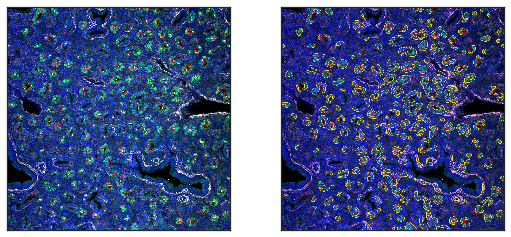

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
for ax, im in zip(axes, [im, im1]):
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])

In [9]:
base_dir = '/Users/cliburn/Dropbox/LungMapImages'
filename = '2015-004-015_60X_C57BL6_PND28_LMM.15.24A.6L.38_NKX2.1_EMCN_ACTA2_001.tif'
path = os.path.join(base_dir, filename)
structure = "green_cells"

im = read_image(path)
contours, im1 = rules[structure](im)

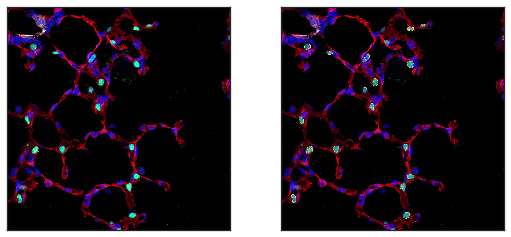

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
for ax, im in zip(axes, [im, im1]):
    ax.imshow(im)
    ax.set_xticks([])
    ax.set_yticks([])

### Check that exported JSON file preserves data

In [11]:
with open('info.json') as f:
    info1 = json.load(f, object_hook=as_python_object)

In [12]:
info.keys()

['contour_(x,y)', 'img_file', 'center', 'structure', 'area']

In [13]:
info1.keys()

[u'contour_(x,y)', u'img_file', u'center', u'structure', u'area']

In [14]:
for c1, c2 in zip(info['contour_(x,y)'], info1['contour_(x,y)']):
    assert(np.all(c1 == c2))